In [1]:
import numpy as np
import argparse
import sys
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import  ActivityRegularization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.keras import utils as np_utils

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
#print(device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

gpus = tf.config.experimental.list_physical_devices('GPU') 
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Settings -----------

SOURCE_IMG_WIDTH = 224
SOURCE_IMG_HEIGHT = SOURCE_IMG_WIDTH

DATA_PATH = 'Data' +str(SOURCE_IMG_WIDTH)+ '\\'
# Settings -----------

# Fix the random seed for reproducibility
seed = 7
np.random.seed(seed)

Default GPU Device:  /device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Data Generators

# Data augmentation should only apply to the training set (If any)
train_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))

valid_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest")

test_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))


train_generator = train_datagen.flow_from_directory(
    directory=DATA_PATH + 'train\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb", #rgb
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory=DATA_PATH + 'val\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=DATA_PATH + 'test\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    #save_to_dir="preview\\",
    #save_prefix ="TEST_",
    #save_format="tif",
    seed=42
)

np.save('labels', train_generator.class_indices)

Found 18603 images belonging to 33 classes.
Found 9297 images belonging to 33 classes.
Found 9306 images belonging to 33 classes.


In [4]:
# Model defination
resnet_model = ResNet50(include_top=False, layers=tf.keras.layers, input_shape=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH, 3), weights='imagenet')

for layer in resnet_model.layers:
    layer.trainable = False
    

# Check the trainable status of the individual layers
#for layer in resnet_model.layers:
#    print(layer.name, layer.trainable)

model = Sequential()
model.add(resnet_model)
model.add(Conv2D(512,(2,2),name='convNew',padding='same'))
model.add(BatchNormalization(axis=-1,name='banNew'))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', name='fc-2', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(ActivityRegularization(l2=0.01, l1=0.01))
model.add(Dropout(.2))
model.add(Dense(33, activation='softmax', name='outputLayer'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
convNew (Conv2D)             (None, 7, 7, 512)         4194816   
_________________________________________________________________
banNew (BatchNormalization)  (None, 7, 7, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
fc-2 (Dense)                 (None, 128)               65664     
_________________________________________________________________
activity_regularization (Act (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc_top = ModelCheckpoint('res_best_top_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=False)
mc = ModelCheckpoint('res_best_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=False)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
convNew (Conv2D)             (None, 7, 7, 512)         4194816   
_________________________________________________________________
banNew (BatchNormalization)  (None, 7, 7, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
fc-2 (Dense)                 (None, 128)               65664     
_________________________________________________________________
activity_regularization (Act (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [6]:
EPOCHS = 10

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc_top, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  18:02:09
Epoch 1/10
581/581 [==============================] - ETA: 0s - loss: 4.5130 - accuracy: 0.1412
Epoch 00001: val_accuracy improved from -inf to 0.06476, saving model to resnet_top_checkpoint.h5
581/581 [==============================] - 139s 238ms/step - loss: 4.5130 - accuracy: 0.1412 - val_loss: 4.4450 - val_accuracy: 0.0648
Epoch 2/10
581/581 [==============================] - ETA: 0s - loss: 3.4800 - accuracy: 0.2210
Epoch 00002: val_accuracy did not improve from 0.06476
581/581 [==============================] - 64s 110ms/step - loss: 3.4800 - accuracy: 0.2210 - val_loss: 4.0041 - val_accuracy: 0.0592
Epoch 3/10
581/581 [==============================] - ETA: 0s - loss: 3.1334 - accuracy: 0.2541
Epoch 00003: val_accuracy did not improve from 0.06476
581/581 [==============================] - 63s 109ms/step - loss: 3.1334 - accuracy: 0.2541 - val_loss: 3.8172 - val_accuracy: 0.0583
Epoch 4/10
581/581 [==============================] - ETA: 0s - loss: 

In [7]:
model.load_weights("res_best_top_checkpoint.h5")

# accuracy 90%
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
'''
for layer in model.layers:
    if(layer.name=="resnet50"):
        for ly in layer.layers:
            print(ly.name, ly.trainable)
    print(layer.name, layer.trainable)        
'''

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])

In [8]:
EPOCHS = 200

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  18:13:02
Epoch 1/200
581/581 [==============================] - ETA: 0s - loss: 2.1627 - accuracy: 0.5698
Epoch 00001: val_accuracy improved from -inf to 0.06832, saving model to resnet_checkpoint.h5
581/581 [==============================] - 118s 203ms/step - loss: 2.1627 - accuracy: 0.5698 - val_loss: 3.9820 - val_accuracy: 0.0683
Epoch 2/200
581/581 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.7441
Epoch 00002: val_accuracy improved from 0.06832 to 0.37554, saving model to resnet_checkpoint.h5
581/581 [==============================] - 112s 193ms/step - loss: 1.6441 - accuracy: 0.7441 - val_loss: 2.8432 - val_accuracy: 0.3755
Epoch 3/200
581/581 [==============================] - ETA: 0s - loss: 1.4485 - accuracy: 0.7882
Epoch 00003: val_accuracy improved from 0.37554 to 0.46196, saving model to resnet_checkpoint.h5
581/581 [==============================] - 112s 192ms/step - loss: 1.4485 - accuracy: 0.7882 - val_loss: 2.6969 - val_ac

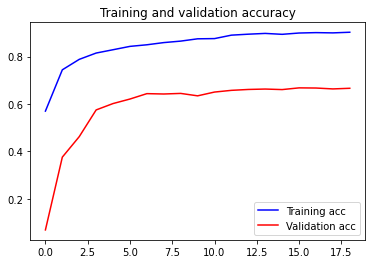

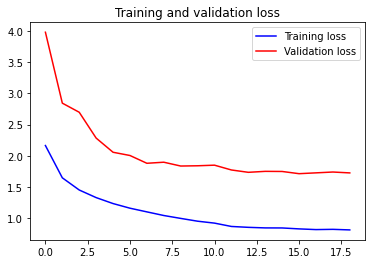

In [9]:
# Plot the accuracy and loss curves
acc = history_pre.history['accuracy']
val_acc = history_pre.history['val_accuracy']
loss = history_pre.history['loss']
val_loss = history_pre.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model = models.load_model('res_best_checkpoint.h5')

if os.path.isfile('labels.npy'):
    class_indices = np.load('labels.npy',allow_pickle=True).item()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
scores = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST) 
print("Test Loss =", scores[0], "Test Accuracy =", scores[1])

Test Loss = 0.8161737322807312 Test Accuracy = 0.8920051455497742


[0]
['Acinetobacter.baumanii']


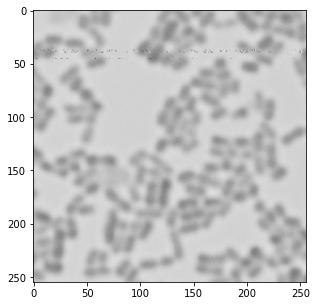

In [11]:
# Manual test
img = image.load_img('data\\test\\Acinetobacter.baumanii\\Acinetobacter.baumanii_0004_30.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 


[13]
['Lactobacillus.gasseri']


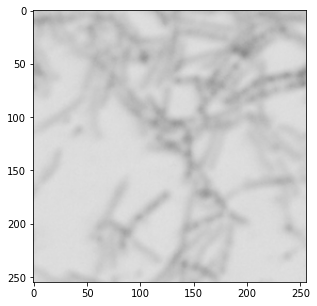

In [12]:
img = image.load_img('data\\test\\Lactobacillus.gasseri\\Lactobacillus.gasseri_0004_11.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 


Confusion Matrix


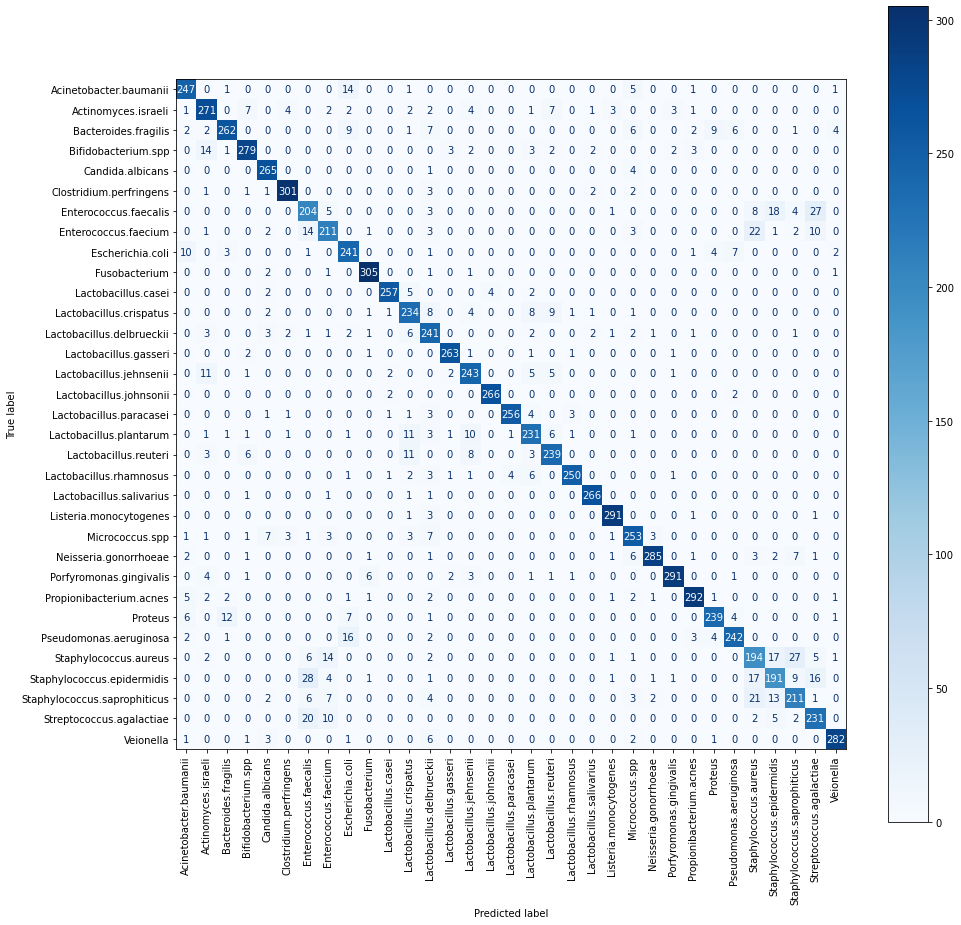

Classification Report
                              precision    recall  f1-score   support

      Acinetobacter.baumanii       0.89      0.91      0.90       270
         Actinomyces.israeli       0.86      0.87      0.86       311
        Bacteroides.fragilis       0.93      0.84      0.88       311
         Bifidobacterium.spp       0.92      0.90      0.91       311
            Candida.albicans       0.91      0.98      0.95       270
     Clostridium.perfringens       0.96      0.97      0.97       311
       Enterococcus.faecalis       0.73      0.76      0.74       270
        Enterococcus.faecium       0.81      0.78      0.80       270
            Escherichia.coli       0.82      0.89      0.85       270
               Fusobacterium       0.96      0.98      0.97       311
         Lactobacillus.casei       0.97      0.95      0.96       270
     Lactobacillus.crispatus       0.84      0.87      0.85       270
   Lactobacillus.delbrueckii       0.78      0.89      0.83       2

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#model = models.load_model('resnet_checkpoint.h5')
#model = models.load_model('resnet50.h5')
#class_indices = np.load('labels.npy',allow_pickle=True).item()

#np.set_printoptions(threshold=np.inf) # to see the full confusion matrix
np.set_printoptions(threshold=1000) #

#Confusion Matrix and Classification Report

Y_pred = model.predict_generator(test_generator,test_generator.n)
y_pred = np.argmax(Y_pred, axis=1)
target_names = class_indices

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.rcParams["figure.figsize"] = (15,15)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))